# 1 ЧАСТЬ

In [1]:
# импорт библиотек:
import warnings
warnings.filterwarnings('ignore')

import optuna
import mlflow
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf

from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from lib.custom_classes_for_pipeline import LogData

mlflow.set_tracking_uri("http://127.0.0.1:6000")
client=mlflow.MlflowClient(tracking_uri='http://127.0.0.1:6000')
# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# чтение данных:
contract = pd.read_csv('Files/contract_new.csv', parse_dates=['BeginDate'])
personal = pd.read_csv('Files/personal_new.csv')
internet = pd.read_csv('Files/internet_new.csv')
phone = pd.read_csv('Files/phone_new.csv')

In [3]:
# функция для исследования каждого датафрейма:
def analyse_df(df):
    display(df.head())
    display(df.info())
    try:
        display(df.select_dtypes(exclude=['object']).describe())
    except:
        pass
    display(df.select_dtypes(include=['object']).describe(include='all'))
    try:
        df.hist(bins=100, figsize=(10,6))
    except:
        pass

# Contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


None

,BeginDate,MonthlyCharges
count,7043,7043.000000
mean,2017-04-30 13:01:50.918642688,64.761692
min,2013-10-01 00:00:00,18.250000
25%,2015-06-01 00:00:00,35.500000
50%,2017-09-01 00:00:00,70.350000
75%,2019-04-01 00:00:00,89.850000
max,2020-02-01 00:00:00,118.750000
std,NaN,30.090047


,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043
unique,7043,67,3,2,4,6658
top,7590-VHVEG,No,Month-to-month,Yes,Electronic check,
freq,1,5942,3875,4171,2365,11


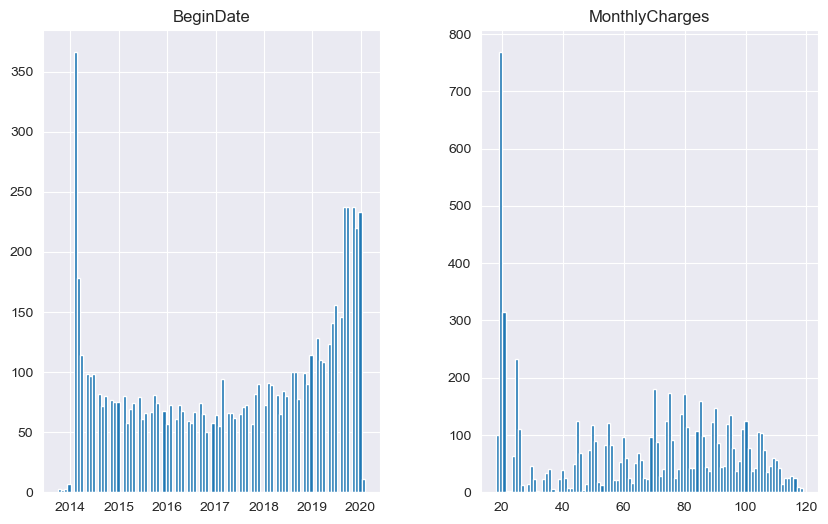

In [4]:
analyse_df(contract)

После вывода общей информации можно отметить, что:
- в данных нет пропусков;
- значение No в столбце EndDate означает, что клиент не отказывался от услуг компании;
- нужно добавить целевой признак Churn, который будет означать, отказался клиент от услуг или нет;
- столбец EndDate имеет строковый тип данных, а должен иметь формат даты;
- столбец TotalCharges имеет строковый тип данных, а должен быть float (на распределение значений посмотрим после преобразования данных);
- возможно, признак MonthlyCharges имеет смысл прологарифмировать в дальнейшем и посмотреть результат;
- после выделения целевого признака нужно будет заменить No в столбце EndDate на дату выгрузки датасета (2020.02.01);
- необходимо создать столбец, отражающий продолжительность жизни клиента в компании в днях;
- столбцы BeginDate и EndDate стоит удалить после получения из них всей необходимой информации (например, стоит вывести признаки, соответствующие месяцу и году начала пользования услугами, и посмотреть, коррелируют ли эти данные с чем-либо и влияют ли на результат);
- к столбцам, содержащим категориальные данные (Type, PaperlessBilling, PaymentMethod), возможно лучше будет применить кодирование в зависимости от используемой модели).

По гистограммам распределения видно, что большинство клиентов начали сотрудничество с компанией в 2014 году, затем увеличение притока клиентов произошло в 2019-2020 годах. Также у большинства клиентов ежемесячные траты на услуги составляют около 20, что является минимальным значением. Самый популярный способ оплаты - помесячный, а также клиенты чаще предпочитают получать счета в электронном виде и оплачивать их при помощи электронного чека.

# Personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,7590-VHVEG,Male,No,No
freq,1,3555,3641,4933


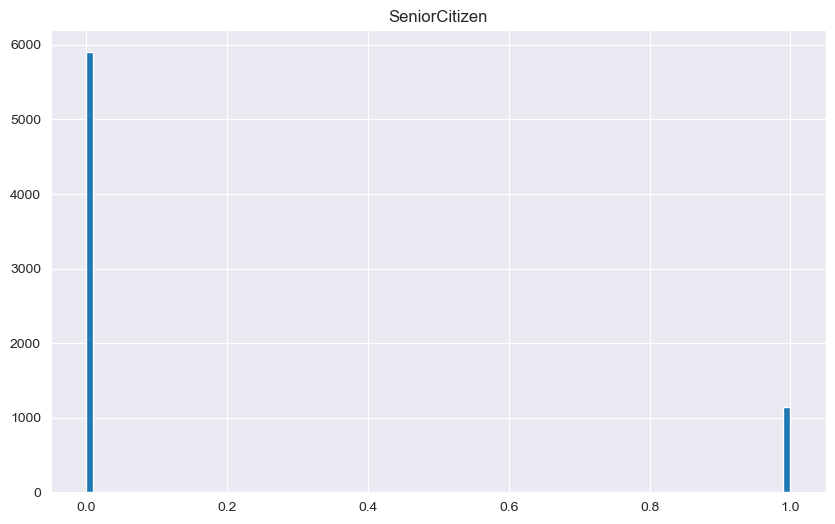

In [5]:
analyse_df(personal)

После вывода общей информации можно отметить, что:
- в данных нет пропусков;
- к столбцам, содержащим категориальные данные (gender, Partner, Dependents) возможно лучше будет применить кодирование в зависимости от используемой модели).

# Internet

In [6]:
analyse_df(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


После вывода общей информации можно отметить, что:
- в данных нет пропусков;
- все столбцы в этом датасете содержат категориальные данные, и возможно к ним лучше будет применить кодирование в зависимости от используемой модели).

# Phone

In [7]:
analyse_df(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


После вывода общей информации можно отметить, что:
- в данных нет пропусков;
- к столбцу MultipleLines, содержащему категориальные данные, возможно лучше будет применить кодирование в зависимости от используемой модели).

После исследования данных во всех четырех датасетах можно отметить следующее:
- в каждом датасете присутствует полный набор данных, т.е. пропусков в них нет, однако каждый датасет имеет разное количество строк (информации о клиентах), следовательно, при объединении четырех датасетов в один для дальнейшей работы пропуски обязательно появятся, и необходимо подумать, как с ними поступить/чем их заполнить;
- в датасетах есть как числовые, так и категориальные признаки, однако последних - большинство;
- аномалии в данных отсутствуют.

# План работы:

1) Изучить данные в файлах, проверить типы, пропуски, аномалии, нужно ли преобразовывать данные (выполнено)
2) Подготовить данные на основе выводов, полученных на предыдущем шаге
3) Кодирование и масштабирование данных с учетом выбранных моделей
4) Исследование задачи: планирую попробовать следующие модели:
- линейную,
- модель бустинга (XGBoost и CatBoost),
- нейронную сеть

5) Проверка качества лучшей модели и исследование важности ее признаков
6) Написание отчета о проделанной работе

# 2 ЧАСТЬ

## Предобработка данных

In [8]:
# создадим целевой столбец Churn:
contract['Churn'] = contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

In [9]:
# заменим все значения "No" в EndDate на дату выгрузки датасета:
contract['EndDate'] = contract['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

In [10]:
# перевод столбца EndDate в формат даты:
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

In [11]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Churn             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 495.3+ KB


In [12]:
# создадим новый столбец Lifetime, показывающий, сколько дней пользователь оставался клиентом компании:
contract['Lifetime'] = (contract['EndDate'] - contract['BeginDate']).dt.days

In [13]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Lifetime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0,153


In [14]:
# переведем TotalCharges в числовой тип:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors ='coerce')

In [15]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   Lifetime          7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


В столбце TotalCharges появились пропуски, посмотрим на строки с ними:

In [16]:
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Lifetime
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Из данных видно, что BeginDate совпадает с EndDate, значит, эти пользователи только стали клиентами компании, поэтому заменим пропуски в столбце TotalCharges на 0.


In [17]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)

In [18]:
contract['TotalCharges'].isna().sum()

0

## Объединение датафреймов

Объединим датафреймы по признаку customerID. Будем выполнять левое соединение, сохраняя все строки из первого фрейма данных, т.к. он является самым объемным и содержит информацию о договоре, а также целевой признак.

In [19]:
df = contract.merge(personal, how='left', on='customerID')\
    .merge(internet, how='left', on='customerID')\
    .merge(phone, how='left',on='customerID')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   Lifetime          7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

In [21]:
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Lifetime',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

In [22]:
# проверим, что все значения customerID уникальные:
df['customerID'].is_unique

True

In [23]:
# установим customerID в качестве индекса:
df = df.set_index('customerID')

In [24]:
# удалим столбцы BeginDate и EndDate:
df = df.drop(['BeginDate', 'EndDate'], axis=1)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Lifetime,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Churn             7043 non-null   int64  
 6   Lifetime          7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

None

,MonthlyCharges,TotalCharges,Churn,Lifetime,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.156325,898.555729,0.162147
std,30.090047,2112.742814,0.363189,683.130510,0.368612
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,276.000000,0.000000
50%,70.350000,1343.350000,0.000000,761.000000,0.000000
75%,89.850000,3236.690000,0.000000,1461.000000,0.000000
max,118.750000,9221.380000,1.000000,2314.000000,1.000000


,Type,PaperlessBilling,PaymentMethod,gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,3,2,4,2,2,2,2,2,2,2,2,2,2,2
top,Month-to-month,Yes,Electronic check,Male,No,No,Fiber optic,No,No,No,No,No,No,No
freq,3875,4171,2365,3555,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390


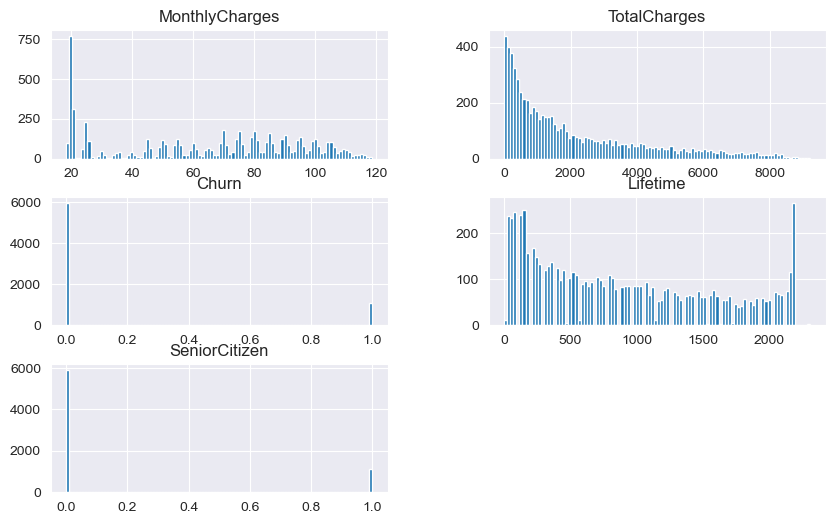

In [25]:
analyse_df(df)

Пропуски в InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines скорее всего означают, что услуги не подключены. Заменим пропуски на 'No'. В дальнейшем попробуем прологарифмировать атрибуты MonthlyCharges, TotalCharges и Lifetime. Самый популярный месяц для притока новых клиентов в компанию - февраль. Большинство новых договоров было подписано в 2019 году, на втором месте - 2014.

In [26]:
df = df.fillna('No')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Churn             7043 non-null   int64  
 6   Lifetime          7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null 

In [28]:
df.dtypes

Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
Lifetime              int64
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
MultipleLines        object
dtype: object

Исследуем признаки на мультиколлинеарность.

In [29]:
# построим 𝜙k correlation matrix:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Churn', 'Lifetime', 'SeniorCitizen']


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Lifetime,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
Type,1.00,0.11,0.28,0.39,0.47,0.09,0.63,0.00,0.09,0.18,0.15,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.07
PaperlessBilling,0.11,1.00,0.37,0.47,0.20,0.08,0.03,0.00,0.24,0.01,0.17,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.25
PaymentMethod,0.28,0.37,1.00,0.40,0.34,0.21,0.35,0.00,0.29,0.24,0.22,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.34
MonthlyCharges,0.39,0.47,0.40,1.00,0.71,0.23,0.39,0.01,0.30,0.20,0.18,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.68
TotalCharges,0.47,0.20,0.34,0.71,1.00,0.30,0.85,0.00,0.14,0.38,0.08,0.49,0.52,0.62,0.64,0.55,0.64,0.64,0.57
Churn,0.09,0.08,0.21,0.23,0.30,1.00,0.37,0.01,0.09,0.23,0.05,0.06,0.13,0.23,0.22,0.10,0.20,0.22,0.26
Lifetime,0.63,0.03,0.35,0.39,0.85,0.37,1.00,0.00,0.06,0.45,0.20,0.06,0.40,0.41,0.43,0.40,0.34,0.34,0.40
gender,0.00,0.00,0.00,0.01,0.00,0.01,0.00,1.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00
SeniorCitizen,0.09,0.24,0.29,0.30,0.14,0.09,0.06,0.00,1.00,0.02,0.32,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.22
Partner,0.18,0.01,0.24,0.20,0.38,0.23,0.45,0.00,0.02,1.00,0.65,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.22


In [30]:
# посмотрим, с какими признаками сильнее всего коррелирует/связан целевой атрибут:
phik_target = phik_overview['Churn'].sort_values(ascending=False).iloc[1:]
phik_target.round(2)

Lifetime            0.37
TotalCharges        0.30
MultipleLines       0.26
OnlineBackup        0.23
Partner             0.23
MonthlyCharges      0.23
StreamingMovies     0.22
DeviceProtection    0.22
PaymentMethod       0.21
StreamingTV         0.20
OnlineSecurity      0.13
TechSupport         0.10
Type                0.09
SeniorCitizen       0.09
PaperlessBilling    0.08
InternetService     0.06
Dependents          0.05
gender              0.01
Name: Churn, dtype: float64

In [31]:
# посчитаем среднее значение коэффициентов корреляции:
mean = phik_target.mean()
mean

0.17159320554071525

In [32]:
# посмотрим на разницу коэффициентов корреляции со средним значением:
phik_target = pd.DataFrame(phik_target)
phik_target['Difference'] = phik_target['Churn'] - mean
phik_target

,Churn,Difference
Lifetime,0.374569,0.202976
TotalCharges,0.302890,0.131297
MultipleLines,0.261237,0.089643
OnlineBackup,0.229482,0.057889
Partner,0.226688,0.055095
MonthlyCharges,0.226280,0.054687
StreamingMovies,0.222232,0.050639
DeviceProtection,0.218380,0.046787
PaymentMethod,0.214832,0.043239
StreamingTV,0.200198,0.028605


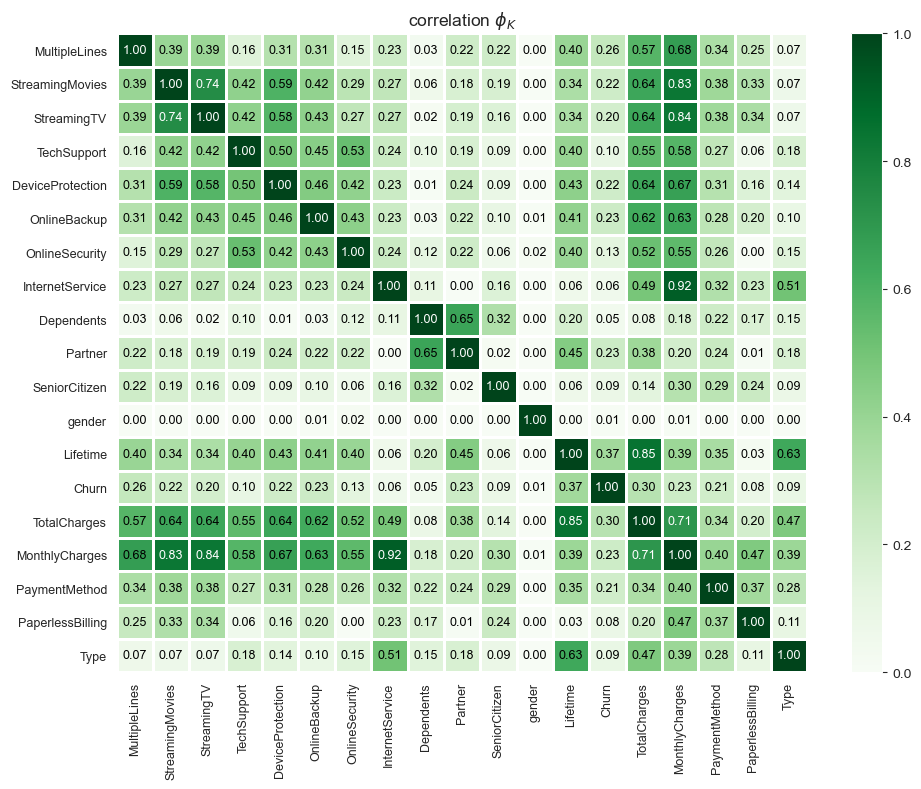

In [33]:
# построим plot_correlation_matrix:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.9,
                        figsize=(10, 8))
plt.tight_layout()

Матрица корреляции свидетельствует о том, что самая сильная связь найдена между атрибутами:
- InternetService и MonthlyCharges (0.92)
- Lifetime и TotalCharges (0.85)
- StreamingTV и MonthlyCharges (0.84)
- StreamingMovies и MonthlyCharges (0.83)
- StreamingMovies и StreamingTV (0.74)
- TotalCharges и MonthlyCharges (0.71)

С целевым признаком сильнее всего связаны следующие атрибуты:
- Lifetime
- TotalCharges
- MultipleLines

Далее важность этих признаков сравним с помощью алгоритма градиентного бустинга, посмотрим, будут ли они совпадать.

## Разделение на выборки

In [34]:
RANDOM_STATE = 250423
TEST_SIZE = 0.25

In [35]:
X = df.drop(['Churn'], axis = 1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

## Кодирование и масштабирование

In [36]:
# создадим кастомный класс для логарифмирования данных:
# class LogData(BaseEstimator, TransformerMixin):
# 
#     def __init__(self, col_to_log):
#         self.col_to_log = col_to_log
# 
#     def transform(self, X):
#         for col in X.columns:
#             if col in self.col_to_log:
#                 X.loc[:, col] = np.log(1 + X.loc[:, col])
#         return X
# 
#     def fit(self, X, y=None):
#         return self

In [37]:
# список колонок, которые будем логарифмировать:
col_to_log = ['MonthlyCharges',
               'TotalCharges',
               'Lifetime']

In [38]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

In [39]:
pipe_cat = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='error', drop='first'))
])

pipe_num = Pipeline([
    ('log', LogData(col_to_log)),
    ('scal', StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", pipe_cat, categorical_features),
    ("num", pipe_num, numeric_features)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='mlogloss'))
])

In [40]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('enc',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod', 'gender',
                                                   'Partner', 'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'MultipleLines']),
                                                 ('num',
                                                  Pipeline(s...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=250423, ...))])

In [41]:
# запишем в переменную названия колонок:
col_enc = pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['enc'].get_feature_names_out().tolist()
col_names = col_enc + numeric_features

In [42]:
feature_imp = list(pipe.named_steps['model'].feature_importances_)

In [43]:
feature_imp = pd.Series(feature_imp, index= col_names).sort_values(ascending=False)

In [44]:
feature_imp

Type_Two year                            0.108302
MultipleLines_Yes                        0.088747
PaymentMethod_Mailed check               0.080406
Partner_Yes                              0.074748
Lifetime                                 0.067657
OnlineBackup_Yes                         0.062072
Type_One year                            0.061895
InternetService_Fiber optic              0.045540
DeviceProtection_Yes                     0.040766
MonthlyCharges                           0.039945
TotalCharges                             0.039807
SeniorCitizen                            0.037677
OnlineSecurity_Yes                       0.031296
PaperlessBilling_Yes                     0.027004
StreamingMovies_Yes                      0.026949
PaymentMethod_Electronic check           0.026422
Dependents_Yes                           0.025394
PaymentMethod_Credit card (automatic)    0.025233
gender_Male                              0.024238
InternetService_No                       0.024173


In [45]:
# функция для создания графика отображения feature importances:
def feature_importance_barplot(features):
    features_to_draw = pd.Series(features, name = 'Feature importance').sort_values(ascending=False)

    f, ax = plt.subplots()
    sns.set_color_codes("muted")
    sns.barplot(x=features_to_draw.values,
                y=features_to_draw.index,
                color="b")
    ax.set(ylabel="Features",
           xlabel="Feature importance")

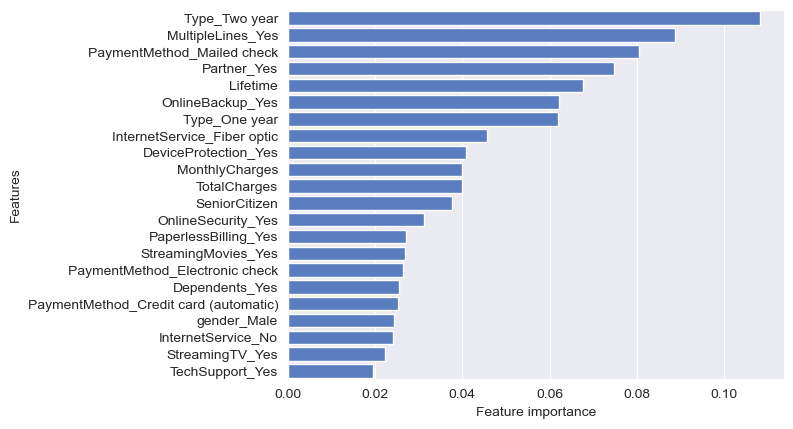

In [46]:
feature_importance_barplot(feature_imp)

В показателях коэффициентов корреляции, а также значимости признаков, посчитанной моделью градиентного бустинга, можно найти определенные совпадения. Низкие коэффициенты корреляции, практически отсутствие связи с целевым признаком, а также низкую значимость имеют следующие атрибуты:
- gender,
- Dependents,
- PaperlessBilling,
- TechSupport,
- OnlineSecurity.

Удалим их из выборок X_train и X_test.

In [47]:
X_train = X_train.drop(['gender',
                        'Dependents',
                        'PaperlessBilling',
                        'TechSupport',
                        'OnlineSecurity'], axis=1)

X_test = X_test.drop(['gender',
                      'Dependents',
                      'PaperlessBilling',
                      'TechSupport',
                      'OnlineSecurity'], axis=1)

In [48]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

In [49]:
# pipe_cat = Pipeline([
#     ('enc', OneHotEncoder(handle_unknown='ignore', drop='first'))
# ])
# 
# pipe_num = Pipeline([
#     ('log', LogData(col_to_log)),
#     ('scal', StandardScaler())
# ])
# 
# preprocessor = ColumnTransformer([
#     ("cat", pipe_cat, categorical_features),
#     ("num", pipe_num, numeric_features)
# ])
# 
# pipe = Pipeline([
#     ('preprocessor', preprocessor),
#     ('model', xgb.XGBClassifier(random_state=RANDOM_STATE))
# ])

## Обучение моделей
Используем GridSearchCV для перебора четырех моделей с их гиперпараметрами:
- логистическая регрессия;
- случайный лес;
- модель градиентного бустинга;
- нейронная сеть.
### Логистическая регрессия

In [50]:
pipe_cat = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

pipe_num = Pipeline([
    ('log', LogData(col_to_log)),
    ('scal', StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", pipe_cat, categorical_features),
    ("num", pipe_num, numeric_features)
])

In [51]:
def optuna_optimize(trial):
    param = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga']),
        'C': trial.suggest_float('C', 0.01, 100),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'tol': trial.suggest_float('tol', 1e-4, 1e-2)
    }

    if param['solver'] == 'lbfgs':
        param['penalty'] = 'l2'
    elif param['solver'] == 'saga':
        param['penalty'] = trial.suggest_categorical('penalty', ['elasticnet', 'l1', 'l2'])
        if param['penalty'] == 'elasticnet':
            param['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)

    estimator = LogisticRegression(**param,
                                   random_state=RANDOM_STATE)

    log_reg_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])

    score = cross_val_score(log_reg_pipe, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

In [52]:
study_log_reg = optuna.create_study(study_name="LogisticRegression Optuna Optimization",
                                    direction='maximize')

[I 2024-09-10 07:04:29,852] A new study created in memory with name: LogisticRegression Optuna Optimization


In [53]:
study_log_reg.optimize(optuna_optimize, n_trials=1000)

[I 2024-09-10 07:04:35,429] Trial 0 finished with value: 0.7256328564268627 and parameters: {'solver': 'saga', 'C': 27.08940436649879, 'max_iter': 789, 'tol': 0.006236818574490126, 'penalty': 'l1'}. Best is trial 0 with value: 0.7256328564268627.
[I 2024-09-10 07:04:35,907] Trial 1 finished with value: 0.725527790577286 and parameters: {'solver': 'saga', 'C': 6.020460919304779, 'max_iter': 850, 'tol': 0.00517217731985402, 'penalty': 'l1'}. Best is trial 0 with value: 0.7256328564268627.
[I 2024-09-10 07:04:36,403] Trial 2 finished with value: 0.7259510178130548 and parameters: {'solver': 'saga', 'C': 16.07817592559471, 'max_iter': 488, 'tol': 0.0019855870876747863, 'penalty': 'l2'}. Best is trial 2 with value: 0.7259510178130548.
[I 2024-09-10 07:04:36,732] Trial 3 finished with value: 0.7254248623186259 and parameters: {'solver': 'saga', 'C': 59.30633124896199, 'max_iter': 274, 'tol': 0.008740842021802857, 'penalty': 'l1'}. Best is trial 2 with value: 0.7259510178130548.
[I 2024-09-10

In [54]:
print("Наилучшие значения гиперпараметров Logistic Regression: {}".format(study_log_reg.best_params))
print("ROC-AUC на обучающем наборе: {:.3f}". format(study_log_reg.best_value))

Наилучшие значения гиперпараметров Logistic Regression: {'solver': 'lbfgs', 'C': 35.590142930558095, 'max_iter': 171, 'tol': 0.004675930030382564}
ROC-AUC на обучающем наборе: 0.726


### Случайный лес

In [55]:
pipe_cat = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

pipe_num = Pipeline([
    ('log', LogData(col_to_log))
])

preprocessor = ColumnTransformer([
    ("cat", pipe_cat, categorical_features),
    ("num", pipe_num, numeric_features)
])

In [56]:
def optuna_optimize(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  
        'max_depth': trial.suggest_int('max_depth', 3, 20),  
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])      
    }

    if param['bootstrap']:
        param['max_samples'] = trial.suggest_float('max_samples', 0.5, 1.0)

    estimator = RandomForestClassifier(**param,
                                       random_state=RANDOM_STATE)

    rf_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])

    score = cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

In [57]:
study_rf = optuna.create_study(study_name="RandomForest Optuna Optimization",
                               direction='maximize')

[I 2024-09-10 07:08:39,057] A new study created in memory with name: RandomForest Optuna Optimization


In [58]:
study_rf.optimize(optuna_optimize, n_trials=1000)

[I 2024-09-10 07:08:48,215] Trial 0 finished with value: 0.821375487496441 and parameters: {'n_estimators': 879, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 6, 'bootstrap': False}. Best is trial 0 with value: 0.821375487496441.
[I 2024-09-10 07:08:55,750] Trial 1 finished with value: 0.8136929395483381 and parameters: {'n_estimators': 906, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 4, 'bootstrap': False}. Best is trial 0 with value: 0.821375487496441.
[I 2024-09-10 07:09:07,789] Trial 2 finished with value: 0.8254473031277654 and parameters: {'n_estimators': 726, 'max_depth': 15, 'min_samples_leaf': 8, 'min_samples_split': 5, 'bootstrap': False}. Best is trial 2 with value: 0.8254473031277654.
[I 2024-09-10 07:09:18,997] Trial 3 finished with value: 0.8298085152866829 and parameters: {'n_estimators': 823, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 10, 'bootstrap': False}. Best is trial 3 with value: 0.8298085152866829.
[I 2024-09-10 07:

In [59]:
print("Наилучшие значения гиперпараметров Random Forest: {}".format(study_rf.best_params))
print("ROC-AUC на обучающем наборе: {:.3f}". format(study_rf.best_value))

Наилучшие значения гиперпараметров Random Forest: {'n_estimators': 769, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 6, 'bootstrap': True, 'max_samples': 0.967582076721352}
ROC-AUC на обучающем наборе: 0.836


### XGBoost

In [60]:
pipe_cat = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

pipe_num = Pipeline([
    ('log', LogData(col_to_log))
])

preprocessor = ColumnTransformer([
    ("cat", pipe_cat, categorical_features),
    ("num", pipe_num, numeric_features)
])

In [61]:
def optuna_optimize(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 20.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.0, 5.0)
    }

    estimator = xgb.XGBClassifier(**param,
                                  random_state=RANDOM_STATE)

    xgb_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])

    score = cross_val_score(xgb_pipe, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

In [62]:
study_xgb_smote = optuna.create_study(study_name="XGBoost Optuna Optimization",
                                      direction='maximize')

[I 2024-09-10 09:50:34,449] A new study created in memory with name: XGBoost Optuna Optimization


In [63]:
study_xgb_smote.optimize(optuna_optimize, n_trials=1000)

[I 2024-09-10 09:50:34,896] Trial 0 finished with value: 0.8244850335992812 and parameters: {'n_estimators': 402, 'max_depth': 4, 'learning_rate': 0.2557706160414652, 'gamma': 17.176698997068726, 'reg_lambda': 0.3657403077313923, 'min_child_weight': 3.5432891037925334}. Best is trial 0 with value: 0.8244850335992812.
[I 2024-09-10 09:50:35,209] Trial 1 finished with value: 0.824220661596369 and parameters: {'n_estimators': 239, 'max_depth': 14, 'learning_rate': 0.6417619080228055, 'gamma': 5.248148478182708, 'reg_lambda': 0.8894177931956139, 'min_child_weight': 4.0805647352218894}. Best is trial 0 with value: 0.8244850335992812.
[I 2024-09-10 09:50:35,444] Trial 2 finished with value: 0.826155731961747 and parameters: {'n_estimators': 138, 'max_depth': 11, 'learning_rate': 0.2784492333841957, 'gamma': 13.564515979388219, 'reg_lambda': 0.8283815159021466, 'min_child_weight': 1.0893332617780986}. Best is trial 2 with value: 0.826155731961747.
[I 2024-09-10 09:50:35,785] Trial 3 finished 

In [64]:
print("Наилучшие значения гиперпараметров XGBoost: {}".format(study_xgb_smote.best_params))
print("ROC-AUC на обучающем наборе: {:.3f}". format(study_xgb_smote.best_value))

Наилучшие значения гиперпараметров XGBoost: {'n_estimators': 431, 'max_depth': 2, 'learning_rate': 0.3228642588238987, 'gamma': 0.016672256479682332, 'reg_lambda': 0.28118686702299067, 'min_child_weight': 0.004222027985676703}
ROC-AUC на обучающем наборе: 0.926


### Нейронная сеть

In [65]:
pipe_cat = Pipeline([
    ('enc', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

pipe_num = Pipeline([
    ('log', LogData(col_to_log)),
    ('scal', StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", pipe_cat, categorical_features),
    ("num", pipe_num, numeric_features)
])

In [66]:
def create_model(trial, input_shape):
    n_layers = trial.suggest_int('n_layers', 1, 3)  # Количество скрытых слоев
    units = trial.suggest_int('units', 4, 128)  # Количество нейронов в каждом слое
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)  # Скорость обучения

    np.random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)
    
    model = keras.models.Sequential()

    # Входной слой с динамическим input_shape
    model.add(keras.layers.Dense(units=units, input_shape=(input_shape,), activation='relu'))

    # Добавляем скрытые слои
    for _ in range(n_layers):
        model.add(keras.layers.Dense(units=units, activation='relu'))

    # Выходной слой
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Компиляция модели с оптимизатором Adam
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])

    return model

In [67]:
def optuna_optimize_nn(trial):
    X_train_transformed = preprocessor.fit_transform(X_train)
    input_shape = X_train_transformed.shape[1]  # Количество признаков после предобработки

    # Обертываем нейронную сеть в KerasClassifier с dynamic input shape
    nn_model = KerasClassifier(build_fn=lambda: create_model(trial, input_shape),
                               epochs=trial.suggest_int('epochs', 10, 100),
                               batch_size=trial.suggest_int('batch_size', 16, 128),
                               verbose=0)

    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),  
        ('model', nn_model)              
    ])

    score = cross_val_score(final_pipeline, X_train, y_train, cv=5, scoring='roc_auc').mean()

    return score

In [68]:
study_nn = optuna.create_study(study_name="NN Optuna Optimization",
                                      direction='maximize')

[I 2024-09-10 09:59:20,341] A new study created in memory with name: NN Optuna Optimization


In [69]:
study_nn.optimize(optuna_optimize_nn, n_trials=1000)

[I 2024-09-10 09:59:36,469] Trial 0 finished with value: 0.7962860504422322 and parameters: {'epochs': 96, 'batch_size': 73, 'n_layers': 2, 'units': 88, 'learning_rate': 2.0066806488268374e-05}. Best is trial 0 with value: 0.7962860504422322.
[I 2024-09-10 10:00:19,976] Trial 1 finished with value: 0.8030660401227682 and parameters: {'epochs': 80, 'batch_size': 17, 'n_layers': 1, 'units': 64, 'learning_rate': 0.0459355166790746}. Best is trial 1 with value: 0.8030660401227682.
[I 2024-09-10 10:00:26,808] Trial 2 finished with value: 0.8159700943034032 and parameters: {'epochs': 43, 'batch_size': 85, 'n_layers': 1, 'units': 75, 'learning_rate': 0.0003761668152856007}. Best is trial 2 with value: 0.8159700943034032.
[I 2024-09-10 10:00:31,635] Trial 3 finished with value: 0.8122262620764852 and parameters: {'epochs': 11, 'batch_size': 71, 'n_layers': 3, 'units': 109, 'learning_rate': 0.0011783770099764363}. Best is trial 2 with value: 0.8159700943034032.
[I 2024-09-10 10:00:45,379] Trial

In [70]:
print("Наилучшие значения гиперпараметров NN: {}".format(study_nn.best_params))
print("ROC-AUC на обучающем наборе: {:.3f}". format(study_nn.best_value))

Наилучшие значения гиперпараметров NN: {'epochs': 18, 'batch_size': 56, 'n_layers': 2, 'units': 85, 'learning_rate': 0.0006923474538939642}
ROC-AUC на обучающем наборе: 0.826


In [71]:
# def create_model():
# 
#     np.random.seed(RANDOM_STATE)
#     tf.random.set_seed(RANDOM_STATE)
# 
#     model = keras.models.Sequential()
# 
#     model.add(keras.layers.Dense(units=2, input_dim=17, activation='relu'))
#     model.add(keras.layers.Dense(units=10, activation='relu'))
#     model.add(keras.layers.Dense(units=1, activation='sigmoid'))
# 
#     model.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics='accuracy')
#     return model

In [72]:
# param_grid = [
#     {
#         'model': [LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs')],
#         'model__penalty': [None]
#     },
# 
#     {
#         'model': [LogisticRegression(random_state=RANDOM_STATE, solver='saga')],
#         'model__penalty': ['elasticnet'],
#         'model__C': [0.001, 0.01, 0.1, 1],
#         'model__l1_ratio': [0, 0.5, 1],
#         'model__max_iter': [1000]
#     },
# 
#     {
#         'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
#         'model__n_estimators': [50, 100, 150],
#         'model__max_depth': [10, 15, 20]
#     },
# 
#     {
#         'model': [xgb.XGBClassifier(random_state=RANDOM_STATE)],
#         'model__n_estimators': [250, 300, 350],
#         'model__max_depth': [2, 4, 6],
#         'model__eta': [0.9, 1.1, 1.3]
#     },
# 
#     {
#         'model': [KerasClassifier(model=create_model, verbose=0)],
#         'model__epochs': [50, 70, 100],
#         'model__batch_size': [3, 5, 7]
#     }
# ]

In [73]:
# grid_search = GridSearchCV(estimator=pipe,
#                            param_grid=param_grid,
#                            scoring='roc_auc',
#                            cv=5,
#                            verbose=1).fit(X_train, y_train)

In [74]:
# grid_search.best_params_

In [75]:
# grid_search.best_score_

In [ ]:
# best_model = grid_search.best_estimator_

In [ ]:
joblib.dump(best_model, 'api/best_model.pkl')

## Проверка качества лучшей модели на тестовой выборке

In [ ]:
pred_proba = best_model.predict_proba(X_test)[:, 1]
print('ROC-AUC score на тестовой выборке:', roc_auc_score(y_test, pred_proba))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)

plt.figure(figsize=(6, 4))

plt.plot(fpr, tpr, label=f'XGBClassifier: {round(roc_auc_score(y_test, pred_proba), 4)}')

plt.plot([0, 1], [0, 1], linestyle='--', label='coin')

plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.legend()

plt.show()

In [ ]:
# матрица ошибок:
confusion_matrix(y_test, best_model.predict(X_test))

## Исследование важности признаков лучшей модели

In [ ]:
best_model_features = list(best_model.named_steps['model'].feature_importances_)

In [ ]:
# запишем в переменную названия колонок:
col_enc = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['enc'].get_feature_names_out().tolist()
col_names = col_enc + numeric_features

In [ ]:
best_model_feature_imp = pd.Series(best_model_features, index= col_names).sort_values(ascending=False)

In [ ]:
feature_importance_barplot(best_model_feature_imp)

Исследование важности признаков лучшей модели показало, что самыми значимыми атрибутами являются:
- MultipleLines (наличие возможности ведения параллельных линий во время звонка);
- Type (тип договора);
- OnlineBackup (облачное хранилище файлов для резервного копирования данных).

# 3 часть

В данном проекте проведена работа по предсказанию того, откажется ли клиент от услуг оператора сотовой связи или нет. Все пункты моего плана были выполнены за исключением одного: я решила не строить CatBoost, выбрав только одну модель градиентного бустинга из-за больших временных затрат.

В процессе работы возникали нетривиальные задачи, которые хотелось разобрать, и на них ушло много времени, например:
1) написание отдельного класса для логарифмирования данных;
2) получение оригинальных названий признаков из Pipeline;
3) настройка оболочки KerasClassifier для нейронной сети для использования в гридсерч.

Для преодоления этих трудностей приходилось искать решения в Интернете.

Сначала данные были прочитаны, и по ним были сделаны предварительные выводы.

После этого была произведена первичная обработка данных - изменены типы данных (в столбцах EndDate и TotalCharges) и заполнены пропуски (в столбцах TotalCharges, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines).

Были добавлены 2 новых столбца:
- целевой атрибут Churn, который означает, отказался ли клиент от услуг или нет;
- Lifetime, который означает, сколько дней пользователь оставался клиентом компании.

После этого был проведен исследовательский анализ данных: были проанализированы количественные и категоральные признаки, проведена попытка найти связь между ними и целевым признаком. С целевым признаком сильнее всего связаны атрибуты Lifetime, TotalCharges и MultipleLines, и построение модели градиентного спуска в рамках исследовательского анализа подтвердило важность первого признака.

После этого была проведена подготовка данных к обучению моделей:
- удалены ненужные столбцы (BeginDate, EndDate, а также gender, Dependents, PaperlessBilling, TechSupport и OnlineSecurity, т.к. при построении матрицы корреляции связь не была найдена, а также градиентный бустинг подтвердил незначимость этих признаков);
- датафрейм был разделен на обучающую и тестовую выборки;
- применена техника One Hot Encoding к категориальным признакам;
- данные в столбцах MonthlyCharges, TotalCharges и Lifetime были прологарифмированы для лучшего распределения значений в них;
- проведено масштабирование количественных признаков.

Затем на данных были обучены 4 модели:
- LogisticRegression,
- RandomForestClassifier,
- XGBClassifier,
- нейронная сеть.

Лучший результат показала модель XGBClassifier со значением метрики ROC-AUC в 0.92. Гиперпараметры этой модели:
- eta: 0.9,
- max_depth: 2,
- model__n_estimators: 250.

Список всех признаков, на которых обучалась модель:
1) категориальные:
- Type,
- PaymentMethod,
- Partner,
- InternetService,
- OnlineBackup,
- DeviceProtection,
- StreamingTV,
- StreamingMovies,
- MultipleLines;
2) количественные:
- MonthlyCharges,
- TotalCharges,
- Lifetime,
- SeniorCitizen.

Самые важные признаки, которые определила модель:
- MultipleLines (наличие возможности ведения параллельных линий во время звонка);
- Type (тип договора);
- OnlineBackup (облачное хранилище файлов для резервного копирования данных).

На основе этого EDA был создан ETL-скрипт для автоматического запуска на Airflow: https://github.com/elenasobolevamsc/Airflow/blob/main/dags/include/churn-prediction.sql